In [ ]:
from agents import mcmc
from agents.utils import tile_batch
from losses import emb_losses, gradient_losses
from network import mlp_ebm
import torch
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn import manifold, datasets
import os

import tqdm
# os.environ["CUDA_VISIBLE_DEVICES"] = '2'
# torch.cuda.set_device(2)
device = torch.device('cuda')
def get_sample_distribution():
    # Construct Gaussian Mixture Model in 1D consisting of 5 equally
    # weighted normal distributions
    mix = D.Categorical(torch.ones(2,))
    comp = D.Normal(torch.tensor([0.0,4.]), torch.tensor([1.0,1.]))
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm
    # TODO: debug
    # return D.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

def get_distribution_sample(num_sample:int):
    gmm = get_sample_distribution()
    # act_space is 1
    return gmm.sample([num_sample, 1])[:,None].float() # [num_sample, 1, 1]

def get_dataset_sample(num_sample:int):
    X, y = datasets.make_circles(
    n_samples=num_sample, factor=0.5, noise=0.05, random_state=0)
    return X

def make_counter_example_actions(
      observations,  # B x obs_spec
      expanded_actions,  # B x 1 x act_spec
      batch_size,
      cloning_network,
      num_counter_examples, act_shape, act_min=-100, act_max=100):
    """Given observations and true actions, create counter example actions."""
    # Note that T (time dimension) would be included in obs_spec.
    # TODO: obtain action max and min
    high, low = act_max, act_min
    maybe_tiled_obs_n = tile_batch(observations,
                                                  num_counter_examples)
    # Counter example actions [B x num_counter_examples x act_spec]
    random_uniform_example_actions = \
        torch.distributions.uniform.Uniform(low,high).sample(\
            [batch_size, num_counter_examples]+act_shape)
    random_uniform_example_actions = torch.reshape(
          random_uniform_example_actions,
          (batch_size * num_counter_examples, -1))
    # Use all uniform actions to seed the optimization
    _, counter_example_actions, _ = mcmc.iterative_dfo(
        cloning_network,
        batch_size,
        maybe_tiled_obs_n,
        random_uniform_example_actions,
        policy_state=(),
        num_action_samples=num_counter_examples,
        min_actions=low * np.ones(act_shape),
        max_actions=high * np.ones(act_shape))
    
    def concat_and_squash_actions(counter_example, action):
      return torch.reshape(
          torch.concat([counter_example, action], axis=1),
          [-1] + (act_shape))
    counter_example_actions = counter_example_actions.reshape([batch_size, num_counter_examples, -1])
    # print("check mcmc output shape",counter_example_actions.shape, expanded_actions.shape)
    # Batch consists of num_counter_example rows followed by 1 true action.
    # [B * (n + 1) x act_spec]
    combined_true_counter_actions = \
        concat_and_squash_actions(counter_example_actions, expanded_actions)
    return counter_example_actions, combined_true_counter_actions


def train(useGaussian:bool):
    if(useGaussian):
        gmm = get_sample_distribution()
        # get sampling space max and min
        large_sample = gmm.sample([10000])
        act_shape = [1]
        exp_name = 'use_gaussian_small_countersample'
        # plt.title('Demo Gaussian Mixture Model')
        
    else:
        large_sample = get_dataset_sample(10000)
        act_shape = [2]
        exp_name = 'use_sklearn'
    path = './mcmc_exp/'+exp_name+'/'
    if not os.path.exists(path):
        os.makedirs(path)
    if useGaussian:
        plt.hist(large_sample.cpu().numpy(), bins=100)
        plt.savefig('./mcmc_exp/'+exp_name+'/demo.png')
        plt.close()
    sample_max = 5
    sample_min = -3
    print("distribution max min is", sample_max, sample_min)
    batch_size = 2
    num_counter_sample = 4
    
    # default obs
    obs = torch.rand([batch_size,1], dtype=torch.float32)
    network = mlp_ebm.MLPEBM((act_shape[0]+1) , 1, normalizer='Batch').to(device)
    # print (network,[param.shape for param in list(network.parameters())] )
    optim = torch.optim.Adam(network.parameters(), lr=1e-3)
    maybe_tiled_obs = tile_batch(obs, num_counter_sample + 1)

    for i in tqdm.trange(int(1e5)):
        # get data from target distribution
        if (useGaussian):
            data = get_distribution_sample(batch_size)
        else:
            target_data = get_dataset_sample(batch_size)
            data = torch.tensor(target_data)[:,None].float()
        # print("data",data)
        # data.requires_grad_(True).to(device)
        # [B * n , act_spec], [B * (n + 1) , act_spec]
        with torch.no_grad():
            counter_example_actions, combined_true_counter_actions = \
                make_counter_example_actions(obs, data,batch_size,network,\
                    num_counter_sample, act_shape, act_min=sample_min, act_max=sample_max)
        network_inputs = (maybe_tiled_obs,
                        combined_true_counter_actions)
        # [B * n+1]
        assert not torch.isnan(combined_true_counter_actions).all()
        predictions = network(network_inputs)
        # print("check counter example shape",counter_example_actions.shape, combined_true_counter_actions.shape)
        predictions = torch.reshape(predictions,
                                    [batch_size, num_counter_sample + 1])
        optim.zero_grad()
        loss, _ = emb_losses.info_nce(predictions,batch_size,num_counter_sample)
        grad_loss = gradient_losses.grad_penalty(
            network,
            'inf',
            batch_size,
            None,
            maybe_tiled_obs,
            combined_true_counter_actions,
            True,
        )
        # loss += grad_loss
        loss.sum().backward()
        optim.step()
        # print("loss at step",i, loss.sum().item())
        if i%1000 == 0:
            print("loss at step",i, loss.sum().item())
            if useGaussian:
                # check mcmc kl distance
                sampling = counter_example_actions.reshape([-1]).cpu().numpy()
                plt.hist(sampling, bins=100)
                plt.savefig(path+str(i)+'.png')
                plt.close()
                # plt.show()
            else:
                (fig, subplots) = plt.subplots(1,1, figsize=(8,8))
                ax1 = subplots
                # ax2 = subplots[1]
                sampling = counter_example_actions.cpu().numpy()
                ax1.scatter(sampling[:, 0], sampling[:, 1], c="r")
                # ax2.scatter(target_data[:,0], target_data[:,1])
                plt.axis("tight")
                plt.savefig(path+str(i)+'.png')
                plt.close()
                # plt.show()
    

if __name__ == '__main__':
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    train(useGaussian=True)


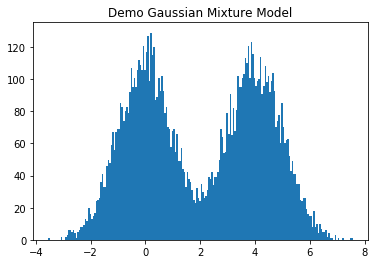

In [10]:
plt.title('Demo Gaussian Mixture Model')
gmm = get_sample_distribution()
large_sample = gmm.sample([10000])
plt.hist(large_sample.cpu().numpy(), bins=200)
plt.show()

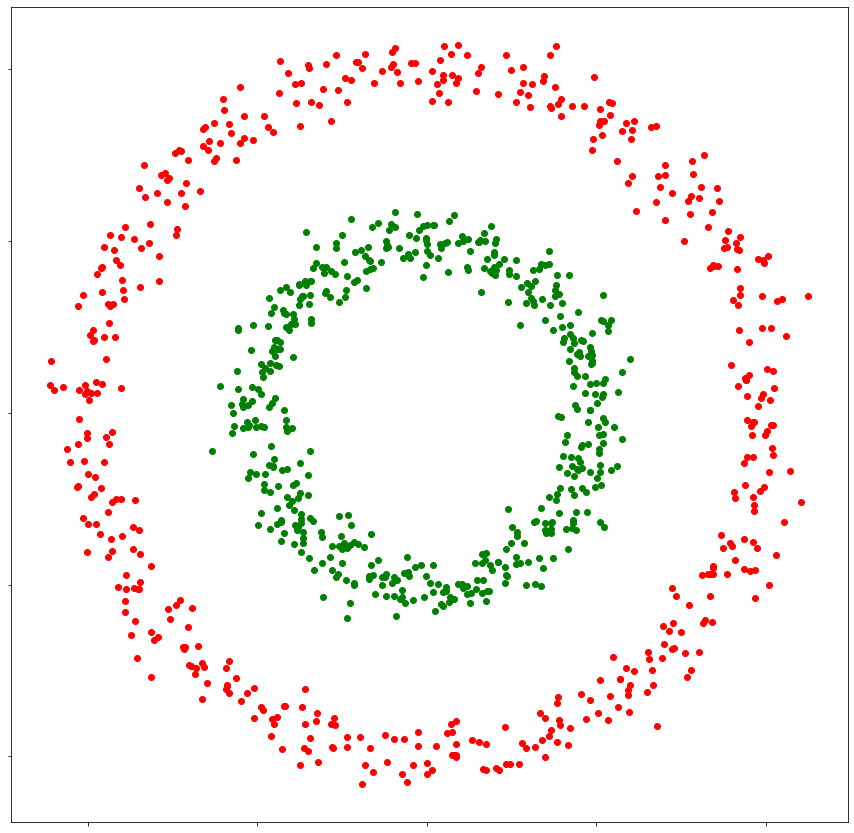

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

n_samples = 1000
n_components = 2
(fig, subplots) = plt.subplots(1,1, figsize=(15, 15))
perplexities = [5, 30, 50, 100]

X, y = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=0
)

red = y == 0
green = y == 1

ax = subplots
ax.scatter(X[red, 0], X[red, 1], c="r")
ax.scatter(X[green, 0], X[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")
plt.savefig('sklearn_demo.png')
plt.show()


In [11]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.distributions as distributions
from network import mlp_ebm
# m = nn.Softmax()
# input = torch.tensor([-1, 0., 1.])
# output = m(input)
# print(output)
# input = torch.tensor([0, 1, 0, 1])
# F.one_hot(input, num_classes=5).shape
# probs = torch.tensor([[0,0,0.5],[0,1,0]])
# batch_size, num_sample = probs.shape
# logits = torch.log(probs)
# m = distributions.Categorical(logits=logits)
# samples = m.sample([num_sample])
# print(samples, samples.T)
# # out = distr.sample()
# out=torch.multinomial(torch.exp(logits), 5,replacement=True)
# print(out)
# input = torch.randint(0, 3, (5,3), dtype=torch.int64)
# input=torch.tensor([[0, 2, 0],
#         [2, 0, 0],
#         [2, 2, 2],
#         [2, 1, 1],
#         [1, 1, 1]])
# batch_size, count = input.shape
# temp = torch.arange(batch_size) * count
# temp = temp[:,None].expand(input.shape)
# print(input, input+temp)
# torch.bincount((input+temp).reshape(-1), minlength=count*batch_size).reshape([batch_size,-1])
# y = input = torch.randint(0, 3, (5,3), dtype=torch.int64)
# print(y)
# torch.tile(y, (3,)).reshape([-1]+list (y.shape[1:]))
# m = nn.Identity()
# input = torch.randn(2, 4)
# output = m(input)
# print(input, output)
# torch.zeros((2,3,4)).shape
# input = torch.randint(0, 3, (5,3), dtype=torch.int64)
# torch.repeat_interleave(torch.arange(15), input.reshape(-1)).shape
# torch.normal(0, 1,size=input.shape).shape
# no_grad = torch.tensor(3.0)
# x = no_grad.clone().detach().requires_grad_(True)
# # with tf.GradientTape() as g:
# #   g.watch(x)
# y = torch.exp(x) * x
# y.backward()
# print(x.grad.data,x, no_grad.requires_grad)
# y_true = [[0, 1], [0, 0]]
# y_pred = [[0.6, 0.4], [0.4, 0.6]]
# kl_numpy = np.array(y_true)*np.log(np.array(y_true)/np.array(y_pred) + 1e-10)
# print(kl_numpy)
# print(kl_numpy.sum(axis=-1))
# kl = nn.KLDivLoss(reduction='none')
# kl( (torch.tensor(y_pred)).log(), (torch.tensor(y_true)+1e-10)).sum(-1)
# batch_size = 2
# nw = 3
# nh = 4
# nc = 5
# nhist = 6
# torch.concat([torch.tensor([batch_size]), torch.tensor([nw, nh, nc * nhist])], dim=0)
batch_size =2
num_counter_examples = 4
# act_shape = [1]
# expanded_actions = torch.rand([batch_size, 1]+act_shape)
# noise = torch.normal(0, torch.ones([batch_size, num_counter_examples]+act_shape))
# random_uniform_example_actions = expanded_actions + noise
# print(expanded_actions,'\n', noise, '\n', random_uniform_example_actions)

actions = torch.rand(batch_size * num_counter_examples,2)
network = mlp_ebm.MLPEBM((3) , 1, dense_layer_type='spectral_norm')
actions = torch.autograd.Variable(actions, requires_grad=True)

obs = torch.rand(batch_size* num_counter_examples,1)
energies = network((obs, actions))

gradients = torch.autograd.grad(outputs=energies, inputs=actions,
                              grad_outputs=torch.ones(energies.size()),
                              create_graph=True, retain_graph=True)[0]
print(gradients)

energies.sum().backward(create_graph=True,retain_graph=True,)
print(actions.grad)

tensor([[-0.0246,  0.0493],
        [-0.0232,  0.0478],
        [-0.0141,  0.0408],
        [-0.0053,  0.0521],
        [-0.0184,  0.0510],
        [-0.0240,  0.0516],
        [-0.0127,  0.0404],
        [-0.0056,  0.0485]], grad_fn=<SliceBackward0>)
tensor([[-0.0246,  0.0493],
        [-0.0232,  0.0478],
        [-0.0141,  0.0408],
        [-0.0053,  0.0521],
        [-0.0184,  0.0510],
        [-0.0240,  0.0516],
        [-0.0127,  0.0404],
        [-0.0056,  0.0485]], grad_fn=<CopyBackwards>)


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
import tensorflow as tf
import numpy as np
# indices = [0, 1, 0, 1]
# depth = 5
# a=tf.one_hot(indices, depth)
# print(a.shape)
# samples = tf.random.categorical(tf.math.log([[0.2,0.3,0.5],[0.5,0.5,0.5]]), 5)
# print(samples)
# tf.identity(a)
# tf.random.normal(a.shape).shape
# x = tf.constant(3.0)
# with tf.GradientTape() as g:
#   g.watch(x)
#   z = tf.exp(x)
#   y = z*z
# dy_dx = g.gradient(y, x)
# print(dy_dx,x)
# x *= x
# with tf.GradientTape() as g:
#   g.watch(x)
#   y = x * x
# dy_dx = g.gradient(y, x)
# print(dy_dx)

# y_true = [[0, 1], [0, 0]]
# y_pred = [[0.6, 0.4], [0.4, 0.6]]
# kl_numpy = np.array(y_true)*np.log(np.array(y_true)/np.array(y_pred) + 1e-10)

# print(np.array(y_true)*np.log(np.array(y_true)/np.array(y_pred)+ 1e-10))
# print(kl_numpy.sum(axis=-1))
# # Using 'auto'/'sum_over_batch_size' reduction type.
# kl = tf.keras.losses.KLDivergence()
# kl(y_true, y_pred).numpy()
# kl = tf.keras.losses.KLDivergence(
#     reduction=tf.keras.losses.Reduction.NONE)
# kl(y_true, y_pred).numpy()
# batch_size = 2
# num_action_samples = 2048
# actions_selected = tf.random.categorical([4096])
# repeat_indices = tf.repeat(
#         tf.range(batch_size * num_action_samples), actions_selected)
# print(repeat_indices.shape)
# from tf_agents.specs import tensor_spec, from_spec
# from tf_agents.environments import suite_gym
# from environments.block_pushing import block_pushing
# env = block_pushing.BlockPush(
#         task=block_pushing.BlockTaskVariant.PUSH)
# env = suite_gym.wrap_env(env)
# _observation_spec = env.observation_spec()
# _action_spec = env.action_spec()
# print(_action_spec)

# random_uniform_example_actions = tensor_spec.sample_spec_nest(
#         from_spec(_action_spec),
#         outer_dims=(3, 2048))
# print(random_uniform_example_actions.shape)
# r_np = random_uniform_example_actions.numpy()
# print(r_np.max(), r_np.min(), r_np.mean())
sample = np.random.rand(2,4)
avg_sample, var_sample = tf.nn.moments(
          tf.convert_to_tensor(sample), axes=[0])
print(avg_sample, var_sample, sample, sample.mean(axis=0))

tf.Tensor([0.83920709 0.70998215 0.36152236 0.32822858], shape=(4,), dtype=float64) tf.Tensor([0.01694063 0.07295037 0.00103831 0.00397952], shape=(4,), dtype=float64) [[0.96936325 0.43988888 0.39374516 0.39131203]
 [0.70905092 0.98007542 0.32929956 0.26514513]] [0.83920709 0.70998215 0.36152236 0.32822858]


In [22]:
from environments.particle.particle import ParticleEnv
import gym
import torch
env = ParticleEnv()
batch_size=2
num_action_samples=2048
obs = env.reset()
# obs = torch.tensor(time_step)[None, Ellipsis]
# obs = torch.concat([obs] * (batch_size * num_action_samples),
#                             axis=0)
# "Batch" the observations by replicating
for key in obs.keys():
    batch_obs = torch.tensor(obs[key])[None, Ellipsis]
    obs[key] = torch.concat([batch_obs] * (batch_size * num_action_samples),axis=0)
print(type(env.observation_space.spaces))
num_dict=1
if isinstance(env.observation_space.spaces, dict):
    num_dict = len(env.observation_space.spaces.keys())
print(num_dict)
# env = suite_gym.wrap_env(env)
# obs_spec, act_spec, _ = spec_utils.get_tensor_specs(env)
# for key in list(env.observation_space.spaces):
# env = gym.make("InvertedPendulum-v2")
# obs_dim = env.observation_space.shape[0]
# act_dim = env.action_space.shape[0]
# print("obs space", env.observation_space, "action space",env.action_space)
# print("obs space", obs_dim, "action space",act_dim)

<class 'collections.OrderedDict'>
4


tensor([ 0.3684, -0.3474])


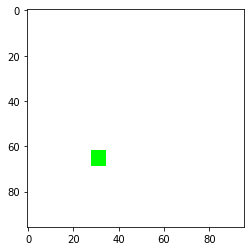

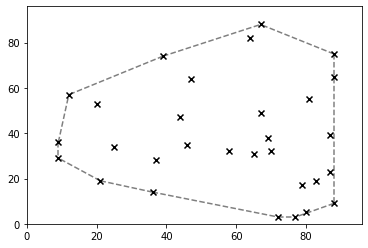

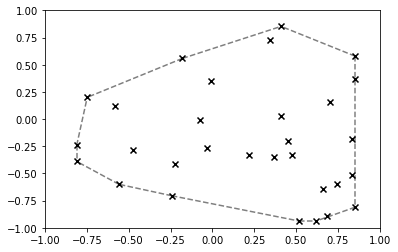

Target bounds:
[[-1. -1.]
 [ 1.  1.]]


In [3]:
import dataclasses
from typing import Optional, Tuple

import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor


@dataclasses.dataclass
class DatasetConfig:
    dataset_size: int = 30
    """The size of the dataset. Useful for sample efficiency experiments."""

    resolution: Tuple[int, int] = (96, 96)
    """The resolution of the image."""

    pixel_size: int = 7
    """The size of the pixel whose coordinates we'd like to regress. Must be odd."""

    pixel_color: Tuple[int, int, int] = (0, 255, 0)
    """The color of the pixel whose coordinates we'd like to regress."""

    seed: Optional[int] = None
    """Whether to seed the dataset. Disabled if None."""


class CoordinateRegression(Dataset):
    """Regress the coordinates of a colored pixel block on a white canvas."""

    def __init__(self, config: DatasetConfig) -> None:
        if not config.pixel_size % 2:
            raise ValueError("'pixel_size' must be odd.")

        self.dataset_size = config.dataset_size
        self.resolution = config.resolution
        self.pixel_size = config.pixel_size
        self.pixel_color = config.pixel_color
        self.seed = config.seed

        self.reset()

    def reset(self) -> None:
        if self.seed is not None:
            np.random.seed(self.seed)

        self._coordinates = self._sample_coordinates(self.dataset_size)
        self._coordinates_scaled = self._scale_coordinates(self._coordinates)

    def exclude(self, coordinates: np.ndarray) -> None:
        """Exclude the given coordinates, if present, from the previously sampled ones.

        This is useful for ensuring the train set does not accidentally leak into the
        test set.
        """
        mask = (self.coordinates[:, None] == coordinates).all(-1).any(1)
        num_matches = mask.sum()
        while mask.sum() > 0:
            self._coordinates[mask] = self._sample_coordinates(mask.sum())
            mask = (self.coordinates[:, None] == coordinates).all(-1).any(1)
        self._coordinates_scaled = self._scale_coordinates(self._coordinates)
        print(f"Resampled {num_matches} data points.")

    def get_target_bounds(self) -> np.ndarray:
        """Return per-dimension target min/max."""
        return np.array([[-1.0, -1.0], [1.0, 1.0]])

    def _sample_coordinates(self, size: int) -> np.ndarray:
        """Helper method for generating pixel coordinates."""
        # Randomly generate pixel coordinates.
        u = np.random.randint(0, self.resolution[0], size=size)
        v = np.random.randint(0, self.resolution[1], size=size)

        # Ensure we remain within bounds when we take the pixel size into account.
        slack = self.pixel_size // 2
        u = np.clip(u, a_min=slack, a_max=self.resolution[0] - 1 - slack)
        v = np.clip(v, a_min=slack, a_max=self.resolution[1] - 1 - slack)

        return np.vstack([u, v]).astype(np.int16).T

    def _scale_coordinates(self, coords: np.ndarray) -> np.ndarray:
        """Helper method for scaling coordinates to the [-1, 1] range."""
        coords_scaled = np.array(coords, dtype=np.float32)
        coords_scaled[:, 0] /= self.resolution[0] - 1
        coords_scaled[:, 1] /= self.resolution[1] - 1
        coords_scaled *= 2
        coords_scaled -= 1
        return coords_scaled

    @property
    def image_shape(self) -> Tuple[int, int, int]:
        return self.resolution + (3,)

    @property
    def coordinates(self) -> np.ndarray:
        return self._coordinates

    @property
    def coordinates_scaled(self) -> np.ndarray:
        return self._coordinates_scaled

    def __len__(self) -> int:
        return self.dataset_size

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        uv = self._coordinates[index]
        uv_scaled = self._coordinates_scaled[index]

        image = np.full(self.image_shape, fill_value=255, dtype=np.uint8)
        image[
            uv[0] - self.pixel_size // 2 : uv[0] + self.pixel_size // 2 + 1,
            uv[1] - self.pixel_size // 2 : uv[1] + self.pixel_size // 2 + 1,
        ] = self.pixel_color

        image_tensor = ToTensor()(image)
        target_tensor = torch.as_tensor(uv_scaled, dtype=torch.float32)

        return image_tensor, target_tensor


if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from scipy.spatial import ConvexHull

    dataset = CoordinateRegression(DatasetConfig(dataset_size=30, seed=0))

    # Visualize one instance.
    image, target = dataset[np.random.randint(len(dataset))]
    print(target)
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.show()

    # Plot target distribution and convex hull.
    targets = dataset.coordinates
    plt.scatter(targets[:, 0], targets[:, 1], marker="x", c="black")
    for simplex in ConvexHull(targets).simplices:
        plt.plot(
            targets[simplex, 0],
            targets[simplex, 1],
            "--",
            zorder=2,
            alpha=0.5,
            c="black",
        )
    plt.xlim(0, dataset.resolution[1])
    plt.ylim(0, dataset.resolution[0])
    plt.show()

    # Plot target distribution and convex hull.
    targets = dataset.coordinates_scaled
    plt.scatter(targets[:, 0], targets[:, 1], marker="x", c="black")
    for simplex in ConvexHull(targets).simplices:
        plt.plot(
            targets[simplex, 0],
            targets[simplex, 1],
            "--",
            zorder=2,
            alpha=0.5,
            c="black",
        )
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()

    print(f"Target bounds:")
    print(dataset.get_target_bounds())


In [2]:
%pip install scipy

  Using cached scipy-1.5.4-cp36-cp36m-manylinux1_x86_64.whl (25.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spinup 0.2.0 requires cloudpickle==1.2.1, but you have cloudpickle 1.6.0 which is incompatible.
spinup 0.2.0 requires gym[atari,box2d,classic_control]~=0.15.3, but you have gym 0.19.0 which is incompatible.
spinup 0.2.0 requires tensorflow<2.0,>=1.8.0, but you have tensorflow 2.6.2 which is incompatible.
spinup 0.2.0 requires torch==1.3.1, but you have torch 1.10.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [13]:
import torch
import numpy as np
time_step = np.random.rand(4)
batch_size = 2
num_action_samples = 2048
print("timestep", time_step)
obs = torch.tensor(time_step)[None, Ellipsis]
obs = torch.concat([obs] * (batch_size * num_action_samples),
                        axis=0)
print(obs.shape)

timestep [0.54878577 0.6373976  0.36660476 0.84392894]
torch.Size([4096, 4])


In [1]:
from stable_baselines3.common.evaluation import evaluate_policy
import gym

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize

env = make_vec_env("HalfCheetah-v3", n_envs=20, seed=0)
# env = VecNormalize(env, training=False, norm_reward=False)
# env = gym.make("HalfCheetah-v3",)
model = PPO.load('baseline_ppo_{i}.pth')
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

KeyboardInterrupt: 